You should me more organized. You are still learning though

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

In [2]:
import warnings
warnings.filterwarnings("ignore")

## Read HDF file and phenotypes

In [3]:
final_SNPs = pd.read_hdf('../../../SNPs_data.hdf5', 'snptable')
print(final_SNPs.shape)
pheno_all = pd.read_csv('../../../../Adjusted-means-for-Agronomic-traits-with-race-and-market-calss-info.txt',
                       sep = '\t', header=0)
pheno_all.head()

(280, 243623)


,supop,market_class,taxa,df_co,dm_co,ch_co,lg_co,gh_co,sw_co,df_mi,...,dm_ne,ch_ne,lg_ne,sw_ne,df,dm,ch,lg,gh,sw
0,MA,black,115m,49,92,50,4,2,20.0,41,...,96,41,4,20.5,49,102,45,3.67,2.5,21.5
1,DJ,pink,6r_42,46,90,41,5,3,29.9,38,...,101,40,5,30.5,47,103,37,5.00,3.0,32.3
2,MA,black,92bg_7,49,87,48,3,3,22.8,44,...,79,33,2,21.7,50,92,39,2.33,2.5,21.7
3,DJ,pinto,92us_1006,46,82,45,1,2,30.3,38,...,78,45,1,29.2,45,90,43,1.33,2.0,31.3
4,MA,cream_caroca,a_285,51,94,55,3,3,22.2,45,...,95,40,3,20.9,52,103,48,3.00,2.5,23.1


Since it is the first analysis I will do some data exploration

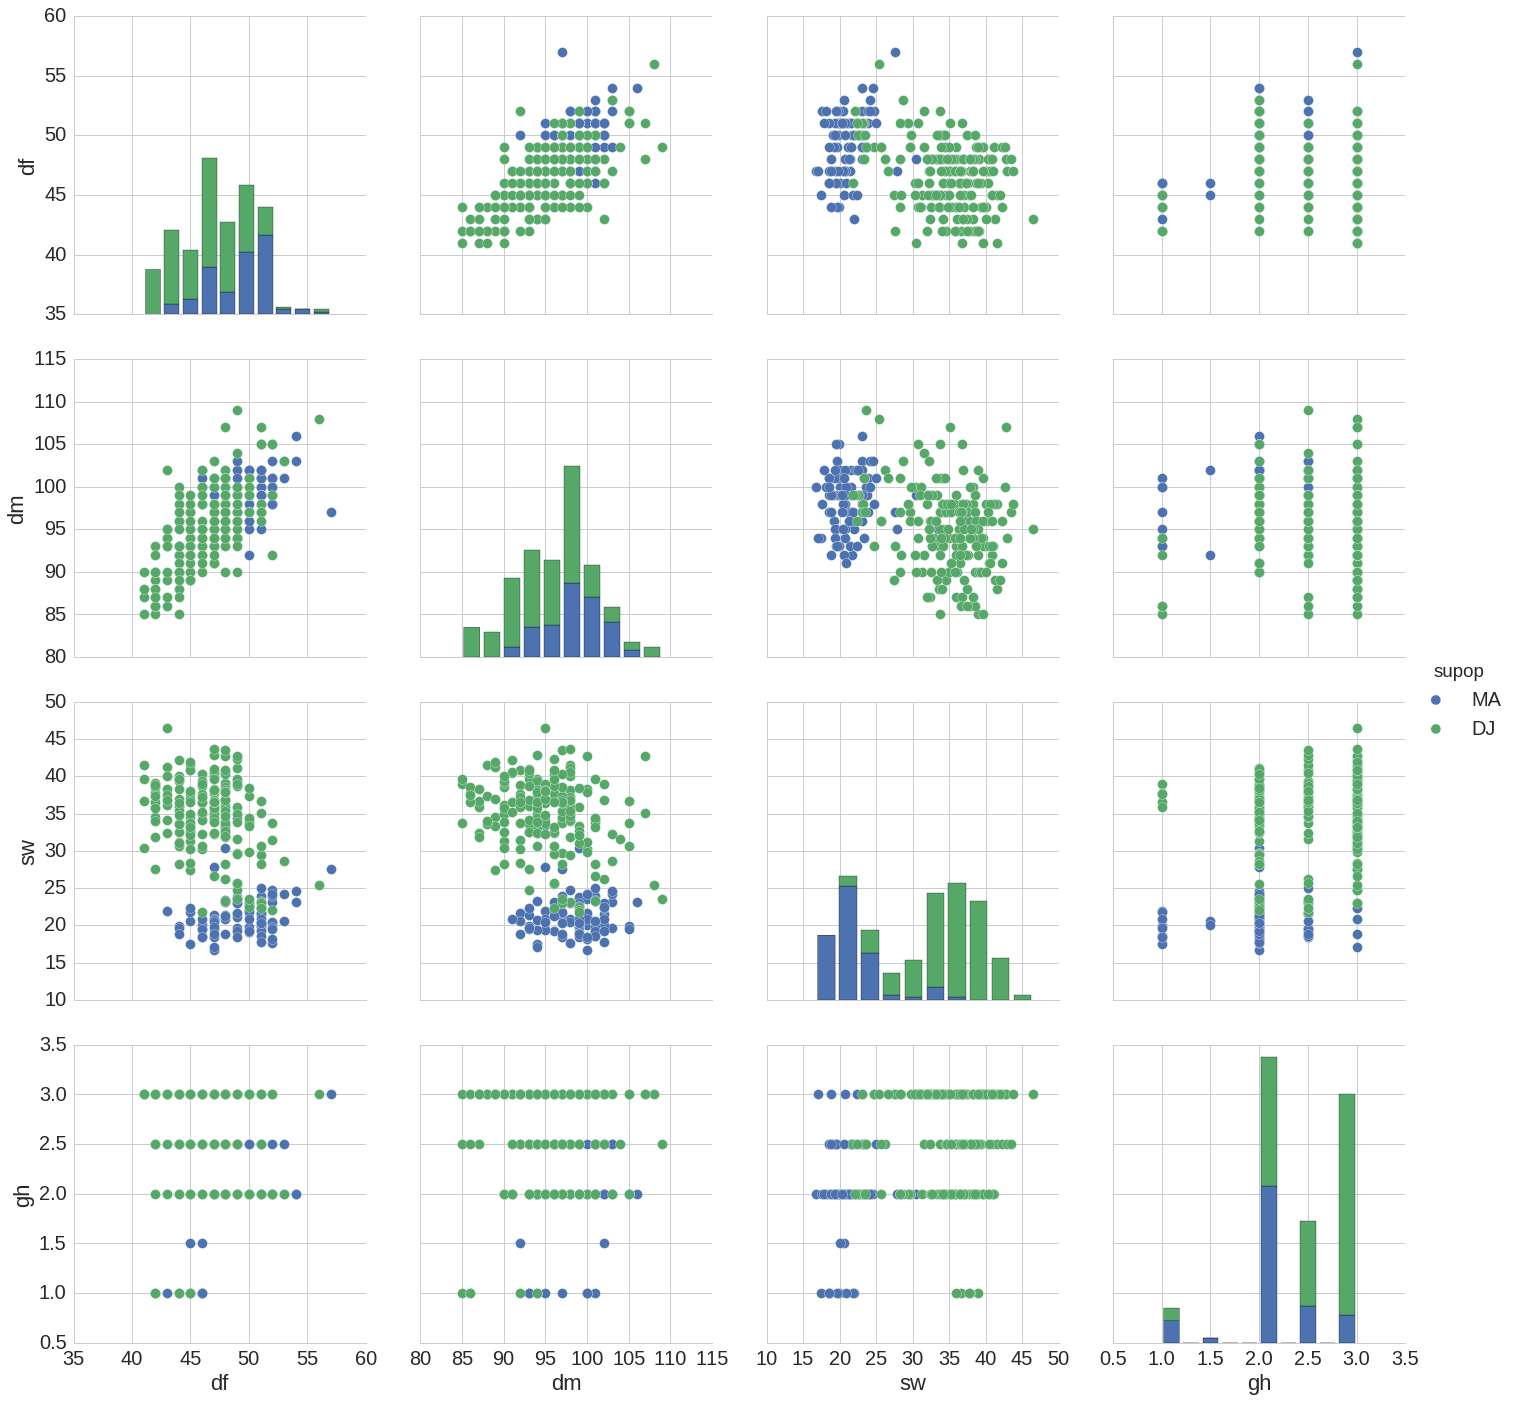

In [4]:
sns.set(font_scale=2)
sns.set_style("whitegrid")
sns.pairplot(pheno_all[['df', 'dm', 'sw', 'gh', 'supop']], hue='supop', size=5, 
             plot_kws={'s':100});

# All collection

Prepare phenotypes and genotypes for ML training

I will use the cross_val_score with **scorer='precision_micro'** for the classification. Then I will plot two graphs (1 DF and 1 DM) with mean +- std of the cv values (use 5 cv)

Create funcion with all the data in the model_prescreen script. N.B. for precision you should use a `make_scorer(precision_score, average=average)` like for precision_recall curve.
return a dataframe with all the prediction x classifier, so you can plot it with seaborn point_plot

I will analyze
1. Early (25 %)
2. Late (75 %)
3. 3 Classes

In [6]:
# import custom module
from model_prescreen import classification_task_score
from sklearn.model_selection import train_test_split

## Stratify byclass

## Early 25%

In [7]:
df = pheno_all['df']
df_classes = pd.qcut(df, q=[0,.25, 1], labels = False)

y = df_classes.values
X = final_SNPs.values

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                   test_size = 0.2,
                                                   stratify = y,
                                                   random_state = 101)

classification_prescreen_early = classification_task_score(X_train, y_train, 
                                                     strat=y_train, scorer='recall',
                                                           cv = 5, jobs=7)

Processing linearSVC model 1 of 9
Processing Bagging model 2 of 9
Processing MLP model 3 of 9
Processing RandomForest model 4 of 9
Processing KNeighbors model 5 of 9
Processing SGD model 6 of 9
Processing GradientBoosting model 7 of 9
Processing LogisticRegression model 8 of 9
Processing SVC model 9 of 9


## Late 25

In [8]:
df = pheno_all['df']
df_classes = pd.qcut(df, q=[0,.75, 1], labels = False)

y = df_classes.values
X = final_SNPs.values

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                   test_size = 0.2,
                                                   stratify = y,
                                                   random_state = 101)

classification_prescreen_late = classification_task_score(X_train, y_train, 
                                                     strat=y_train, scorer='recall',
                                                          cv = 5, jobs=7)

Processing linearSVC model 1 of 9
Processing Bagging model 2 of 9
Processing MLP model 3 of 9
Processing RandomForest model 4 of 9
Processing KNeighbors model 5 of 9
Processing SGD model 6 of 9
Processing GradientBoosting model 7 of 9
Processing LogisticRegression model 8 of 9
Processing SVC model 9 of 9


## 3 classes

In [9]:
df = pheno_all['df']
df_classes = pd.qcut(df, q=[0,.25, .75, 1], labels = False)

y = df_classes.values
X = final_SNPs.values

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                   test_size = 0.2,
                                                   stratify = y,
                                                   random_state = 101)

classification_prescreen_all = classification_task_score(X_train, y_train, 
                                                     strat=y_train, scorer='recall_micro',
                                                         cv = 5, jobs=7)

Processing linearSVC model 1 of 9
Processing Bagging model 2 of 9
Processing MLP model 3 of 9
Processing RandomForest model 4 of 9
Processing KNeighbors model 5 of 9
Processing SGD model 6 of 9
Processing GradientBoosting model 7 of 9
Processing LogisticRegression model 8 of 9
Processing SVC model 9 of 9


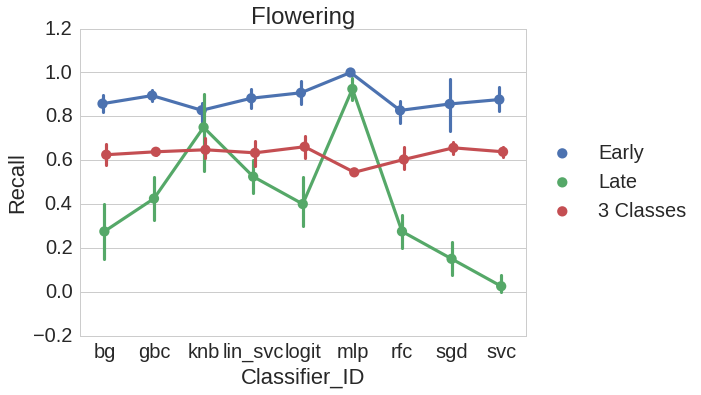

In [10]:
# plot both
classification_prescreen_early['Class']=np.repeat('Early', classification_prescreen_early.shape[0])
classification_prescreen_late['Class']=np.repeat('Late', classification_prescreen_late.shape[0])
classification_prescreen_all['Class']=np.repeat('3 Classes', classification_prescreen_all.shape[0])
two_class = pd.concat([classification_prescreen_early, 
                       classification_prescreen_late, classification_prescreen_all])

sns.pointplot(x='Classifier_ID', y='Score', hue='Class',
                   data = two_class, dodge=True)
plt.ylabel('Recall')
plt.title('Flowering')
#plt.ylim((0,1))
plt.legend(loc='center right', bbox_to_anchor=(1.4, 0.5));

The results are different depending on the scorer used

I will try to optimized KNB for Early and Late first

# Prepare data-Early25%

Prepare data

In [11]:
from sklearn.metrics import precision_score, f1_score, classification_report
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import RandomizedSearchCV
df = pheno_all['df']
df_classes = pd.qcut(df, q=[0,.25, 1], labels = False)
y = df_classes.values
X = final_SNPs.values

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                   test_size = 0.2,
                                                   stratify = y,
                                                   random_state = 101)

# create function for evaluatin shit
def report_res(estimator, X_train, y_train, average):
    y_pred = cross_val_predict(estimator, X_train,
                                 y_train, groups=y_train,
                                 cv = 5, n_jobs=7)
    print(recall_score(y_train, y_pred, average=average))
    print(classification_report(y_train, y_pred))
    return(y_pred)
    

## KNN
Should I keep everything or do it with binary? (let's try

In [17]:
from sklearn.neighbors import KNeighborsClassifier

kn_default = KNeighborsClassifier()
report_res(kn_default, X_train, y_train, 'micro')

0.776785714286
             precision    recall  f1-score   support

          0       0.59      0.65      0.62        62
          1       0.86      0.83      0.84       162

avg / total       0.78      0.78      0.78       224



In [20]:
# silence warnings
#import warnings
#warnings.filterwarnings("ignore")

param_grid = {'n_neighbors':np.linspace(1, 50, 10, dtype=int),
              'weights': ['uniform', 'distance'],
              'metric':['euclidean', 'manhattan', 'minkowski']
             }



kn = KNeighborsClassifier()
kn_search_params = RandomizedSearchCV(kn, param_distributions=param_grid,
                               scoring='recall_micro',n_jobs=7,iid=False,
                               cv=5)

kn_search_params.fit(X_train,y_train)
print(kn_search_params.best_params_)
print(kn_search_params.best_estimator_)
report_res(kn_search_params, X_train, y_train, 'micro')

{'metric': 'euclidean', 'weights': 'uniform', 'n_neighbors': 6}
KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='euclidean',
           metric_params=None, n_jobs=1, n_neighbors=6, p=2,
           weights='uniform')
0.78125
             precision    recall  f1-score   support

          0       0.57      0.82      0.68        62
          1       0.92      0.77      0.84       162

avg / total       0.82      0.78      0.79       224



In [22]:
from sklearn.metrics import confusion_matrix
y_pred = cross_val_predict(kn_search_params, X_train, y_train,
                          groups=y_train, cv = 5, n_jobs=7)

conf_matrix = confusion_matrix(y_train, y_pred)

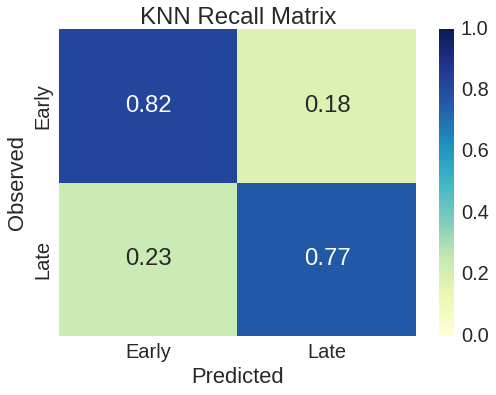

In [39]:
# try different plots of the confusion matrix
norm_matrix = conf_matrix/conf_matrix.sum(axis=1, keepdims=True)
sns.heatmap(norm_matrix, annot=True, 
            xticklabels=['Early', 'Late'],
           yticklabels = ['Early', 'Late'], cmap="YlGnBu",
           vmin=0, vmax=1)
plt.ylabel('Observed')
plt.xlabel('Predicted')
plt.title('KNN Recall Matrix')
plt.show()

## MLP

Best parameters to optimize will be:

* learning_rate

* activation

* alpha : np.logspace(-5, 3, 5)

** se if solver useful (probably not**

In [51]:
from sklearn.neural_network import MLPClassifier

mlp_default = MLPClassifier(random_state=42)
report_res(mlp_default, X_train, y_train, 'micro')

0.723214285714
             precision    recall  f1-score   support

          0       0.00      0.00      0.00        62
          1       0.72      1.00      0.84       162

avg / total       0.52      0.72      0.61       224



In [55]:
y_pred = cross_val_predict(mlp_default, X_train, y_train,
                          groups=y_train, cv = 5, n_jobs=7)
conf_matrix_mlp = confusion_matrix(y_train, y_pred)
norm_matrix_mlp = conf_matrix_mlp/conf_matrix_mlp.sum(axis=1, keepdims=True)
sns.heatmap(norm_matrix_mlp, annot=True, 
            xticklabels=['Early', 'Late'],
           yticklabels = ['Early', 'Late'], cmap="YlGnBu",
           vmin=0, vmax=1)

Process ForkPoolWorker-299:
Process ForkPoolWorker-298:
Process ForkPoolWorker-300:
Process ForkPoolWorker-301:


KeyboardInterrupt: 

In [53]:
y_pred